# Embedding graphs in Minkowski spacetime

> The views of space and time which I wish to lay before you have sprung from the soil of experimental physics, and therein lies their strength. They are radical. Henceforth space by itself, and time by itself, are doomed to fade away into mere shadows, and only a kind of union of the two will preserve an independent reality. — Hermann Minkowski, 1908

![title](lightcone.svg.png)

#### **Implementation of Lorentzian graph embeddings:**

**[1]** Clough JR, Evans TS (2017) Embedding graphs in Lorentzian spacetime. PLoS ONE 12(11):e0187301. https://doi.org/10.1371/journal.pone.0187301<br>

The authors also released their own open-source Python library that can be found here: https://github.com/JamesClough/dagology

**Algorithm Outline:**<br>

1. For every pair $i$ and $j$ connected by a directed path, find length of the longest directed path between them, $L_{i j}$
2. For every other pair, find the naive spacelike distance $N_{i j}$ .
3. Create separation matrix, M, such that M_ is $-L_{i j}^{2}$ if there is a path from $i$ to $j$ and
$N_{i j}^{2}$ otherwise.
4. Use Lorentzian MDS with $\mathrm{M}$ as the input matrix of squared separations.

$$
M_{i j}=M\left(\mathbf{x}_{i}, \mathbf{x}_{j}\right)=-c^{2}\left(x_{i}^{0}-x_{j}^{0}\right)^{2}+\sum_{k=1}^{d}\left(x_{i}^{k}-x_{j}^{k}\right)^{2}
$$

In [51]:
# import libraries
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
# plotting style
%matplotlib inline
plt.style.use('seaborn')
# display multiple outputs within a cell
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all";
# ignore warnings
import warnings
warnings.filterwarnings('ignore');

In [52]:
import networkx as nx

def cube_space_graph(N, D, p=1.0):
    """
    Create a cube space DAG
    Parameters
    ----------
    N - number of vertices in DAG
    D - dimension of box space
    p - probability with which allowed edges appear
    Notes
    -----
    In the cube space model, point a connects to point b iff a has smaller
    coordinates than b in every dimension.
    D=1 is a random DAG
    D=2 is equivalent to Minkowski space with D=2.
    """
    R = np.random.random((N, D))
    G = nx.DiGraph()
    edge_list = []
    for i in range(N):
        G.add_node(i, position=tuple(R[i]))
        for j in range(N):
            if (R[i] > R[j]).all():
                if p == 1. or p > np.random.random():
                    edge_list.append([j,i])
    G.add_edges_from(edge_list)
    return G

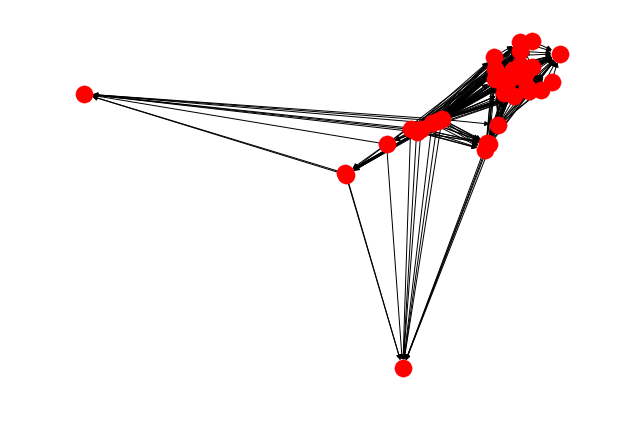

In [53]:
data = cube_space_graph(40, D=2)
nx.draw(data)

In [54]:
def minkowski(x, y, c=1.):
    """Calculate Minkowski separation between x and y using -++...+ convention
    c - speed of light - default to 1."""
    assert len(x) == len(y), 'ERROR - vectors in minkowski have different lengths'
    if np.array_equal(x, y):
        return 0.
    dt = x[0] - y[0]
    dt2 = dt * dt
    dx = np.array([x[i] - y[i] for i in range(1, len(x))])
    dx2 = dx * dx
    dx2sum = sum(dx2) * c * c
    return dx2sum - dt2


def minkowski_periodic(x, y, period, c=1.):
    """Calculate Minkowski separation between x and y using -++...+ convention
       Periodic boundary conditions in spatial coordinates are given in L
       If len(L) < D-1 then assume no boundary on other spatial dimensions"""
    D = len(x)
    assert len(y) == D, 'ERROR - vectors in minkowski have different lengths'
    if np.array_equal(x, y):
        return 0.
        
    while len(period) < (D - 1):
        period.append(None)
    dt = x[0] - y[0]
    dt2 = dt * dt
    ds2 = -1 * dt2
    for d in range(1, D):
        period_d = period[d - 1]  # the first dimension in the coords is time so exclude it
        if period_d:
            dx2 = min((x[d] - y[d])**2, (x[d] - y[d] + period_d)
                      ** 2, (x[d] - y[d] - period_d)**2)
        else:
            dx2 = (x[d] - y[d])**2
        ds2 += dx2
    return ds2

In [55]:
def causal_set_graph(R, p=1.0, periodic=None):
    """
    Create a Causal Set DAG from a set of coordinates, an NxD numpy array
    Parameters
    ----------
    R - coordinates of points
    p - probability with which allowed edges appear
    periodic - list - the periodic size of each dimension
    Notes
    -----
    We are assuming a conformal spacetime - ie. lightcones are straight lines
    and therefore can calculate whether two points should be connected using
    the Minkowski metric.
    """
    G = nx.DiGraph()
    N, D = R.shape
    edgelist = []
    for i in range(N):
        G.add_node(i, position=tuple(R[i]))
        for j in range(N):
            if R[i, 0] < R[j, 0]:
                if p == 1. or p > np.random.random():
                    if periodic:
                        if minkowski_periodic(R[i], R[j], periodic) < 0:
                            edgelist.append([i,j])
                    else:
                        if minkowski(R[i], R[j]) < 0:
                            edgelist.append([i,j])
    G.add_edges_from(edgelist)
    return G

In [181]:
def transitive_completion(A_):
    """ Transitively complete adjacency matrix A"""
    A = A_[:,:]
    A_0 = A[:,:]
    N, _ = A.shape
    A_diff = True
    i = 0
    while A_diff:
        A_old = A[:,:]
        A = np.dot(A, A_0)
        A += A_0
        A[A>1.] = 1.
        if np.array_equal(A_old, A):
            A_diff = False
        assert i < N, 'ERROR - Transitive Completion required more than N steps'
        i += 1
    return A
    
def transitive_reduction(A_, LP=None):
    """ Transitively reduce adjacency matrix A
   
    plan is to look at successive powers of A and if an element is 1 in both
    then it represents an edge which is transitively implied
    we need to do this |LP| times - 
       - could do it N times to be sure (start here)
       - could compute |LP| but that might be slower
       - could allow |LP| as optional input incase it is already calculated
   """
    A = A_[:,:]
    A_0 = A[:,:]
    N, _ = A.shape
    if LP:
        max_path = LP
    else:
        max_path = N
    i = 0
    while i < max_path:
        A = np.dot(A, A_0)
        A = A_0 - A
        A[A<1] = 0
        A[A>1] = 1
        i += 1
    return A

NodeView((0, 1, 2, 3, 4, 5, 6, 7, 8, 9))

OutEdgeView([(0, 3), (0, 6), (2, 3), (2, 6), (2, 8), (4, 1), (4, 7), (5, 2), (5, 3), (5, 6)])

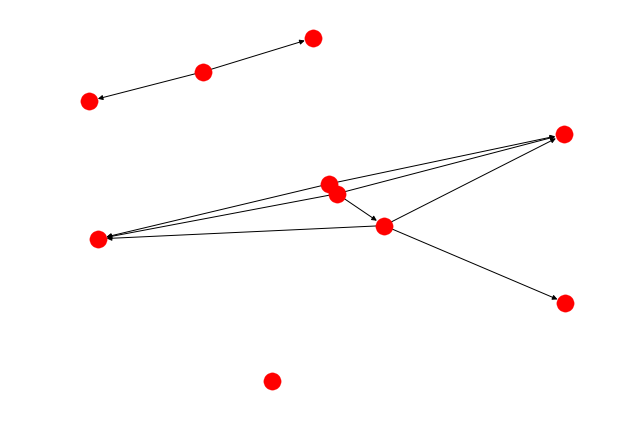

In [240]:
tmp_data = np.random.random((10, 2))
G = causal_set_graph(tmp_data, p=0.6)
G.nodes()
G.edges()
nx.draw(G)

In [241]:
from scipy.sparse.csgraph import dijkstra
#transitive_completion(A) # nodes marked adjacent if there's any connecting path
#transitive_reduction(A) # removes redundant edges to get minimum possible DAG

# get longest path lengths for separation matrix M
def longest_paths(G, max_dist = None):
    A = nx.adjacency_matrix(G).todense()
    if max_dist != None:
        upper_bound = max_dist
    else:
        upper_bound = nx.dag_longest_path_length(G)
    dist_matrix = dijkstra(A, directed=True, limit=upper_bound)**2
    dist_matrix[dist_matrix == np.inf] = upper_bound
    return -dist_matrix
M = longest_paths(G)
M

array([[-0., -2., -2., -1., -2., -2., -1., -2., -2., -2.],
       [-2., -0., -2., -2., -2., -2., -2., -2., -2., -2.],
       [-2., -2., -0., -1., -2., -2., -1., -2., -1., -2.],
       [-2., -2., -2., -0., -2., -2., -2., -2., -2., -2.],
       [-2., -1., -2., -2., -0., -2., -2., -1., -2., -2.],
       [-2., -2., -1., -1., -2., -0., -1., -2., -4., -2.],
       [-2., -2., -2., -2., -2., -2., -0., -2., -2., -2.],
       [-2., -2., -2., -2., -2., -2., -2., -0., -2., -2.],
       [-2., -2., -2., -2., -2., -2., -2., -2., -0., -2.],
       [-2., -2., -2., -2., -2., -2., -2., -2., -2., -0.]])

In [242]:
# get naive spacelike distances if no path i --> j
def naive_distances(A, G):
    n = A.shape[0]
    path_matrix = np.zeros((n, n))
    for i in range(n):
        for j in range(n):
            path_matrix[i, j] = int(nx.has_path(G, i, j))
    max_dist = nx.dag_longest_path_length(G)
    for i in range(n):
        for j in range(n):
            if (path_matrix[i,j] == 0) and (i != j):
                past_i = nx.ancestors(G, i)
                past_j = nx.ancestors(G, j)
                common_past = list(past_i.intersection(past_j))
                future_i = nx.descendants(G, i)
                future_j = nx.descendants(G, j)
                common_future = list(future_i.intersection(future_j))
                naive_dists = []
                if (len(common_past) > 0) and (len(common_future) > 0):
                    for k in common_past:
                        for l in common_future:
                            if nx.has_path(G, source=k, target=l):
                                naive_dists.append(nx.shortest_path_length(G, source=k, target=l))
                            else:
                                naive_dists.append(max_dist)
                    A[i,j] = np.min(naive_dists)
                else:
                    A[i,j] = max_dist
    return A

In [243]:
M_final = naive_distances(M, G)
(M_final == M).all()

True

In [95]:
def longest_path_matrix(A, dmax=None):
    """ Calculate all longest paths and return them in a matrix
    
    Arguments:
    A -- adjacency matrix
    dmax -- maximum path length to be returned
    
    Result should be an NxN assymetric matrix of longest paths
    
    Notes:
    JC - I believe this scales like N**3
         Finding one longest path can be done in linear time
         And we need to find N**2 of them so this is reasonable
        
    JC - The longest path is conjectured to approximate the geodesic in 
         Lorentzian spacetimes but this is not proven to my knowledge 
    """
    N = A.shape[0]
    if dmax is None:
        dmax = N
    LP = np.zeros((N, N))
    i = 1
    B = A[:,:]
    while np.sum(B) > 0.:
        path_exist = np.sign(B)
        path_length = i * path_exist
        LP = np.maximum.reduce((LP, path_length))
        B = np.dot(B, A)
        i += 1
        if i == dmax:
            return LP
    return LP
    
def naive_spacelike_matrix(LP, dmax=None, k=None):  
    """ Calculate all naive spacelike distances and return them in a matrix
    
    Arguments:
    LP -- longest path matrix
    dmax -- maximum spacelike distance to be returned
    k -- only determine distances to k 'landmark' points, and leave the rest
        # this feature needs testing
    
    Result should be an NxN symmetric matrix of negative longest paths
    and positive naive spacelike separations
    
    JC - this seems quite slow when calculated for all N - I think it is the 
         limiting factor on embedding large networks in spacetimes
    """
    if dmax == None:
        dmax = np.max(LP)
    ds = LP + LP.transpose()
    ds2 = ds * ds * -1
    N = LP.shape[0]
    for i in range(N):
        max_j = i
        if k:
            max_j = np.min([i, k])
        for j in range(max_j):
            # spacelike distance is symmetric so ds[i,j]==ds[j,i], and ds[i,i]==0
            if ds2[i,j] == 0:
                # then they are spacelike separated and need a new value here
                i_past = np.flatnonzero(LP[:,i])
                j_past = np.flatnonzero(LP[:,j])
                w_list = np.intersect1d(i_past, j_past)

                i_future = np.flatnonzero(LP[i,:])
                j_future = np.flatnonzero(LP[j,:])
                z_list = np.intersect1d(i_future, j_future)
                if (len(z_list)>0) and (len(w_list)>0):
                    # find min non-zero LP from w to z
                    sp_dist = dmax
                    for w in w_list:
                        for z in z_list:
                            w_z = LP[w, z]
                            if w_z > 0:
                                sp_dist = min(sp_dist, w_z)
                else:
                    sp_dist = dmax
                    
                ds2[i,j] = sp_dist * sp_dist
                ds2[j,i] = sp_dist * sp_dist
    return ds2 

In [ ]:
import networkx as nx
import numpy as np
from random import randrange

import dagology as dag

__all__ = ['random_dag']

def random_dag(degree_sequence):
    """ Create a random DAG from a given degree sequence
    
    Parameters
    ----------
    
    degree_sequence - list of pairs of in, out degrees
    all edges go from earlier to later in this list
    
    Returns
    -------
    
    NetworkX DiGraph
    """
    G = nx.DiGraph()
    G.add_nodes_from(range(len(degree_sequence)))
    remaining_stubs = [] # list of forward pointing stubs
    for node, degrees in enumerate(degree_sequence):
        indegree, outdegree = degrees
        allowed_stubs = remaining_stubs[:]
        for x in range(indegree):
            if len(allowed_stubs) == 0:
                # raise networkx error
                assert False, 'Not a valid degree sequence'
            older_node = allowed_stubs.pop(randrange(len(allowed_stubs)))
            remaining_stubs.remove(older_node)
            # be careful about multiedges
            allowed_stubs = [x for x in allowed_stubs if x != older_node]
            G.add_edge(older_node, node)
        for x in range(outdegree):
            remaining_stubs.append(node)
    return G

In [10]:
def ClassicalMDS(dist_matrix, k):
    """Performs Classical Multidimensional Scaling
    Parameters
    ----------
    dist_matrix : Pairwise dissimilarity/distance matrix (n x n)
    k: Dimension of the output configuration
    
    Returns
    -------
    X : Matrix with columns as the output configuration vectors (k x n)
    """
    # get shape of distance matrix                                                                         
    n = dist_matrix.shape[0]
    
    # check distance matrix is symmetric
    if not np.allclose(np.transpose(dist_matrix),dist_matrix):
        print('Distance matrix must be symmetric')
        return
    
    # centering matrix
    C = np.identity(n) -(1/n)*np.ones((n,n))
    
    # compute gram matrix                                                                                    
    B = -(1/2)*C.dot(dist_matrix**2).dot(C)
    
    # solve for eigenvectors and eigenvalues and sort descending                                                   
    w, v = np.linalg.eigh(B)                                                  
    idx   = np.argsort(w)[::-1]
    eigvals = w[idx]
    eigvecs = v[:,idx]
     
    # select k largest eigenvalues and eigenvectors                      
    Lambda  = np.diag(np.sqrt(eigvals[:k]))
    V  = eigvecs[:,:k]
    X  = np.dot(Lambda, np.transpose(V))
    X = np.transpose(X)

    return X